# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

## Import Resources

In [1]:
# TODO: Make all necessary imports.
# Import TensorFlow 
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

# Ignore some warnings that are not relevant (you can remove this if you prefer)
import warnings
warnings.filterwarnings('ignore')

In [2]:
# TODO: Make all other necessary imports.
import matplotlib.pyplot as plt
import json
import time
import numpy as np

In [3]:
# Some other recommended settings:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
tfds.disable_progress_bar()

In [4]:
print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 tf.keras version:', tf.keras.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')

Using:
	• TensorFlow version: 2.5.0
	• tf.keras version: 2.5.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
	• GPU device not found. Running on CPU


2022-04-25 22:31:18.343888: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [5]:
# TODO: Load the dataset with TensorFlow Datasets.
dataset, dataset_info = tfds.load('OxfordFlowers102',with_info=True,as_supervised = True)

#name the split into each dataset
training_set,validation_set, test_set = dataset['train'], dataset['validation'], dataset['test']


In [6]:
dataset_info

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
    in the United Kingdom. Each class consists of between 40 and 258 images. The images have
    large scale, pose and light variations. In addition, there are categories that have large
    variations within the category and several very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set.
    The training set and validation set each consist of 10 images per class (totalling 1020 images each).
    The test set consists of the remaining 6149 images (minimum 20 per class).
    
    Note: The dataset by default comes with a test size larger than the train
    size. For more info see this [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102/',
    data

## Explore the Dataset

In [7]:
# TODO: Get the number of examples in each set from the dataset info.
num_training_examples = dataset_info.splits['train'].num_examples
num_validation_examples = dataset_info.splits['validation'].num_examples
num_test_examples = dataset_info.splits['test'].num_examples

print("number of train data set:{}".format(num_training_examples))
print("number of validation data set:{}".format(num_validation_examples))
print("number of test data set:{}".format(num_test_examples))

# TODO: Get the number of classes in the dataset from the dataset info.
print("number of classes in the dataset:{}".format(dataset_info.features['label'].num_classes))

number of train data set:1020
number of validation data set:1020
number of test data set:6149
number of classes in the dataset:102


In [64]:
# TODO: Print the shape and corresponding label of 3 images in the training set.
print('The images in our dataset have shape:{}'.format(dataset_info.features['image'].shape))

for image, label in training_set.take(3):
    image = image.numpy().squeeze()
    label = label.numpy()
    print('The label of this image is:', label)
    

The images in our dataset have shape:(None, None, 3)
The label of this image is: 72
The label of this image is: 84
The label of this image is: 70


2022-04-25 22:32:06.952740: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


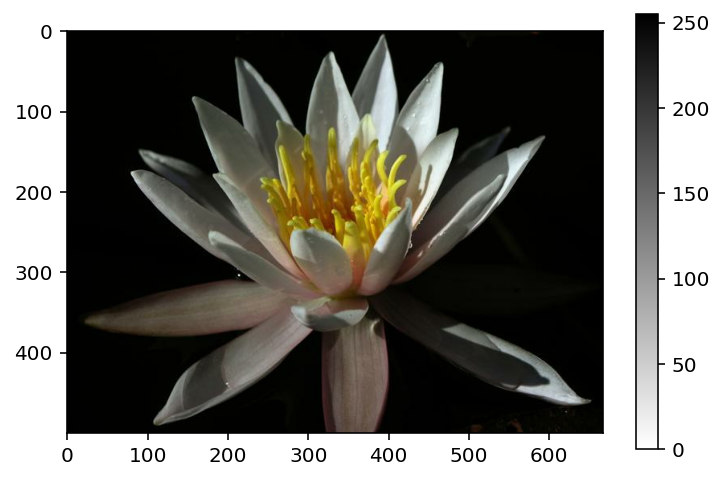

The label of this image is: 72


In [9]:
# TODO: Plot 1 image from the training set. Set the title of the plot to the corresponding image label. 
for image, label in training_set.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()

plt.imshow(image, cmap= plt.cm.binary)
plt.colorbar()
plt.show()

print('The label of this image is:', label)


### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [10]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)
class_names #showing the class_names dictionary

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

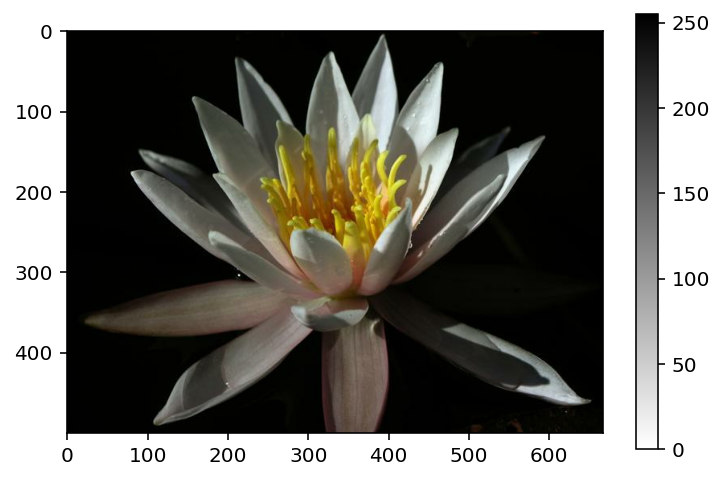

The class name of this image is: azalea


In [11]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 

for image, label in training_set.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()

plt.imshow(image, cmap= plt.cm.binary)
plt.colorbar()
plt.show()

print('The class name of this image is:', class_names[str(label)])

## Create Pipeline

In [12]:
# TODO: Create a pipeline for each set.
batch_size = 64
image_size = 224 #this is to match the size of the pictures MobileNet is trained on

def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image /= 255
    return image, label

training_batches = training_set.shuffle(num_training_examples//4).map(normalize).batch(batch_size).prefetch(1)
validation_batches = validation_set.map(normalize).batch(batch_size).prefetch(1)
testing_batches = test_set.map(normalize).batch(batch_size).prefetch(1)


# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! 

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [32]:
#Load the MobileNet pre-trained network from TensorFlow Hub.
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor = hub.KerasLayer(URL, input_shape=(image_size, image_size, 3))

#setting the pre-trained weights and biases non trainable, so we can freeze them.
feature_extractor.trainable = False


In [33]:
# TODO: Build and train your network.

my_model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(102, activation = 'softmax')
])

my_model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 102)               130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


In [34]:
#train the model to classify the flowers. we only need handfull of epochs as we are using pre-trained model.
my_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

EPOCHS = 5

history = my_model.fit(training_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)



Epoch 1/5
16/16 [==============================] - 41s 2s/step - loss: 4.4223 - accuracy: 0.0657 - val_loss: 3.5714 - val_accuracy: 0.2559
Epoch 2/5
16/16 [==============================] - 34s 2s/step - loss: 2.7537 - accuracy: 0.5490 - val_loss: 2.6002 - val_accuracy: 0.5353
Epoch 3/5
16/16 [==============================] - 64s 4s/step - loss: 1.7368 - accuracy: 0.7980 - val_loss: 1.9998 - val_accuracy: 0.6471
Epoch 4/5
16/16 [==============================] - 58s 4s/step - loss: 1.1260 - accuracy: 0.9176 - val_loss: 1.6466 - val_accuracy: 0.7176
Epoch 5/5
16/16 [==============================] - 42s 3s/step - loss: 0.7849 - accuracy: 0.9510 - val_loss: 1.4343 - val_accuracy: 0.7520


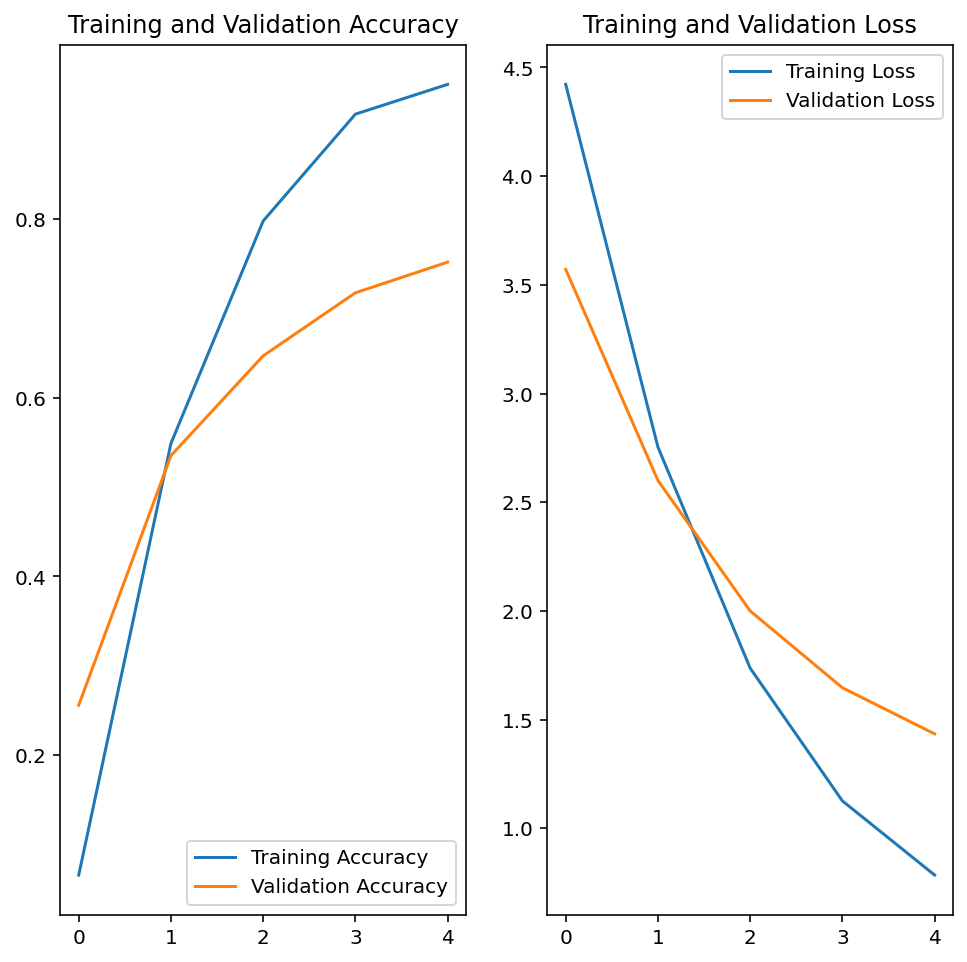

In [35]:
# TODO: Plot the loss and accuracy values achieved during training for the training and validation set.
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(len(training_accuracy))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [37]:
# TODO: Print the loss and accuracy values achieved on the entire test set.

loss, accuracy = my_model.evaluate(testing_batches)

print('\nLoss on the TEST Set: {:,.3f}'.format(loss))
print('Accuracy on the TEST Set: {:.3%}'.format(accuracy))

97/97 [==============================] - 165s 2s/step - loss: 1.5320 - accuracy: 0.7167

Loss on the TEST Set: 1.532
Accuracy on the TEST Set: 71.670%


## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [39]:
# TODO: Save your trained model as a Keras model.
t = time.time()

saved_keras_model_filepath = './my_model_{}.h5'.format(int(t))

my_model.save(saved_keras_model_filepath)


## Load the Keras Model

Load the Keras model you saved above.

In [40]:
# TODO: Load the Keras model
reloaded_keras_model = tf.keras.models.load_model(saved_keras_model_filepath, custom_objects={'KerasLayer':hub.KerasLayer})

reloaded_keras_model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 102)               130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


In [43]:
#this cell is to check there's no difference in original model to the reloaded_keras_model.

for image_batch, label_batch in testing_batches.take(1):
    prediction_1 = my_model.predict(image_batch)
    prediction_2 = reloaded_keras_model.predict(image_batch)
    difference = np.abs(prediction_1 - prediction_2)
    print(difference.max())

0.0


# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [41]:
# TODO: Create the process_image function
image_size = 224

def process_image(image):
    
    image = tf.image.resize(image, (image_size, image_size))
    image /= 255
    image = image.numpy()
    
    return image


To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

shape of the processed image array is:(224, 224, 3)


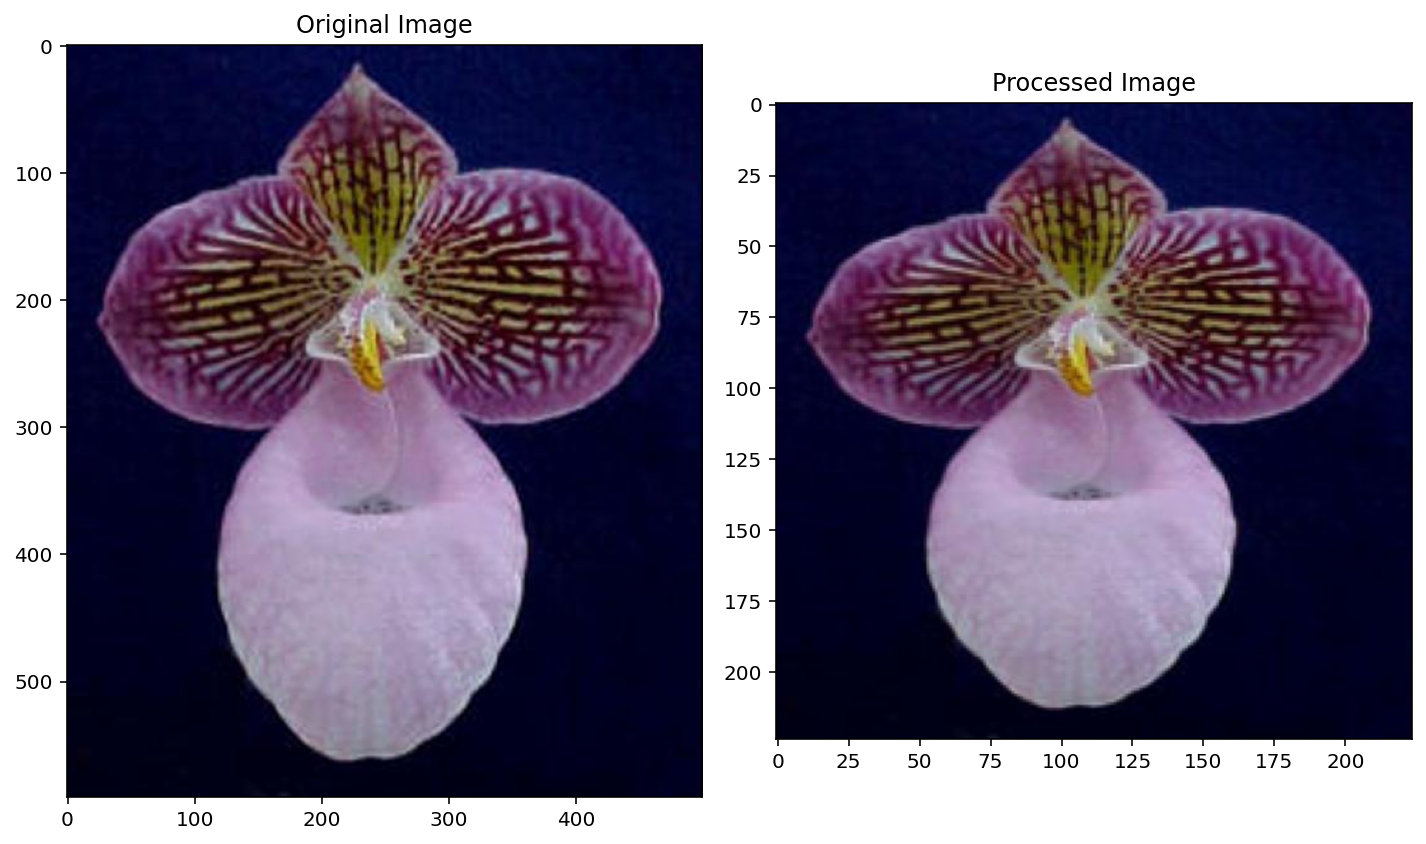

In [42]:
from PIL import Image

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)
print("shape of the processed image array is:{}".format(processed_test_image.shape))

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [59]:
# TODO: Create the predict function

def predict(image_path, model, top_k):
    
    image = Image.open(image_path)
    test_image = np.asarray(image)

    processed_test_image = process_image(test_image)

    converted_test_image = np.expand_dims(processed_test_image, axis=0)
    #below line does the same thing but above line is shorter and more efficient
    #converted_test_image = processed_test_image.reshape(1,processed_test_image.shape[0],processed_test_image.shape[1],processed_test_image.shape[2])
    print("shape of the converted image array is:{}".format(converted_test_image.shape))

    prob_preds= model.predict(converted_test_image)[0]
    
    #predicted_classes = model.predict_classes(converted_test_image, batch_size=batch_size, verbose=0)

    values, indices = tf.math.top_k(prob_preds, k=top_k)
    probs = values.numpy().tolist()
    classes = indices.numpy().tolist()

    return probs, classes
    
probs, classes = predict('./test_images/orange_dahlia.jpg', my_model, 5)
print(probs)
print(classes)

shape of the converted image array is:(1, 224, 224, 3)
[0.22567395865917206, 0.06691205501556396, 0.0654992163181305, 0.06048226356506348, 0.05209250748157501]
[58, 65, 4, 40, 33]


In [61]:
pred_label_names = [class_names[str(idx)] for idx in classes]
print("prediction probabilities :\n", probs)
print('prediction classes:\n', classes)
print('prediction labels:\n', pred_label_names)

prediction probabilities :
 [0.22567395865917206, 0.06691205501556396, 0.0654992163181305, 0.06048226356506348, 0.05209250748157501]
prediction classes:
 [58, 65, 4, 40, 33]
prediction labels:
 ['geranium', 'californian poppy', 'sweet pea', 'lenten rose', 'love in the mist']


# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

In [62]:
# TODO: Plot the input image along with the top 5 classes - this code is still under development

def plot_image(image_path,top_k):
        
    im = Image.open(image_path)
    test_image = np.asarray(im)

    processed_test_image = process_image(test_image)
    converted_test_image = np.expand_dims(processed_test_image, axis=0)
    
    prob_preds= my_model.predict(converted_test_image)
    prob_preds = prob_preds[0].tolist()
    
    values, indices = tf.math.top_k(prob_preds, k=top_k)
    probs = values.numpy().tolist()
    classes = indices.numpy().tolist()
    print(probs)
    print(classes)
    
    fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
    ax1.imshow(processed_test_image)
    ax1.set_title(class_names[str(classes[0])])
    plt.tight_layout()
    plt.show()
    

shape of the converted image array is:(1, 224, 224, 3)
[0.9573736190795898, 0.004676272161304951, 0.004230860620737076, 0.0030360501259565353, 0.0028043922502547503] [1, 5, 6, 67, 79]
[0.9573736190795898, 0.004676272161304951, 0.004230860620737076, 0.0030360501259565353, 0.0028043922502547503]
[1, 5, 6, 67, 79]


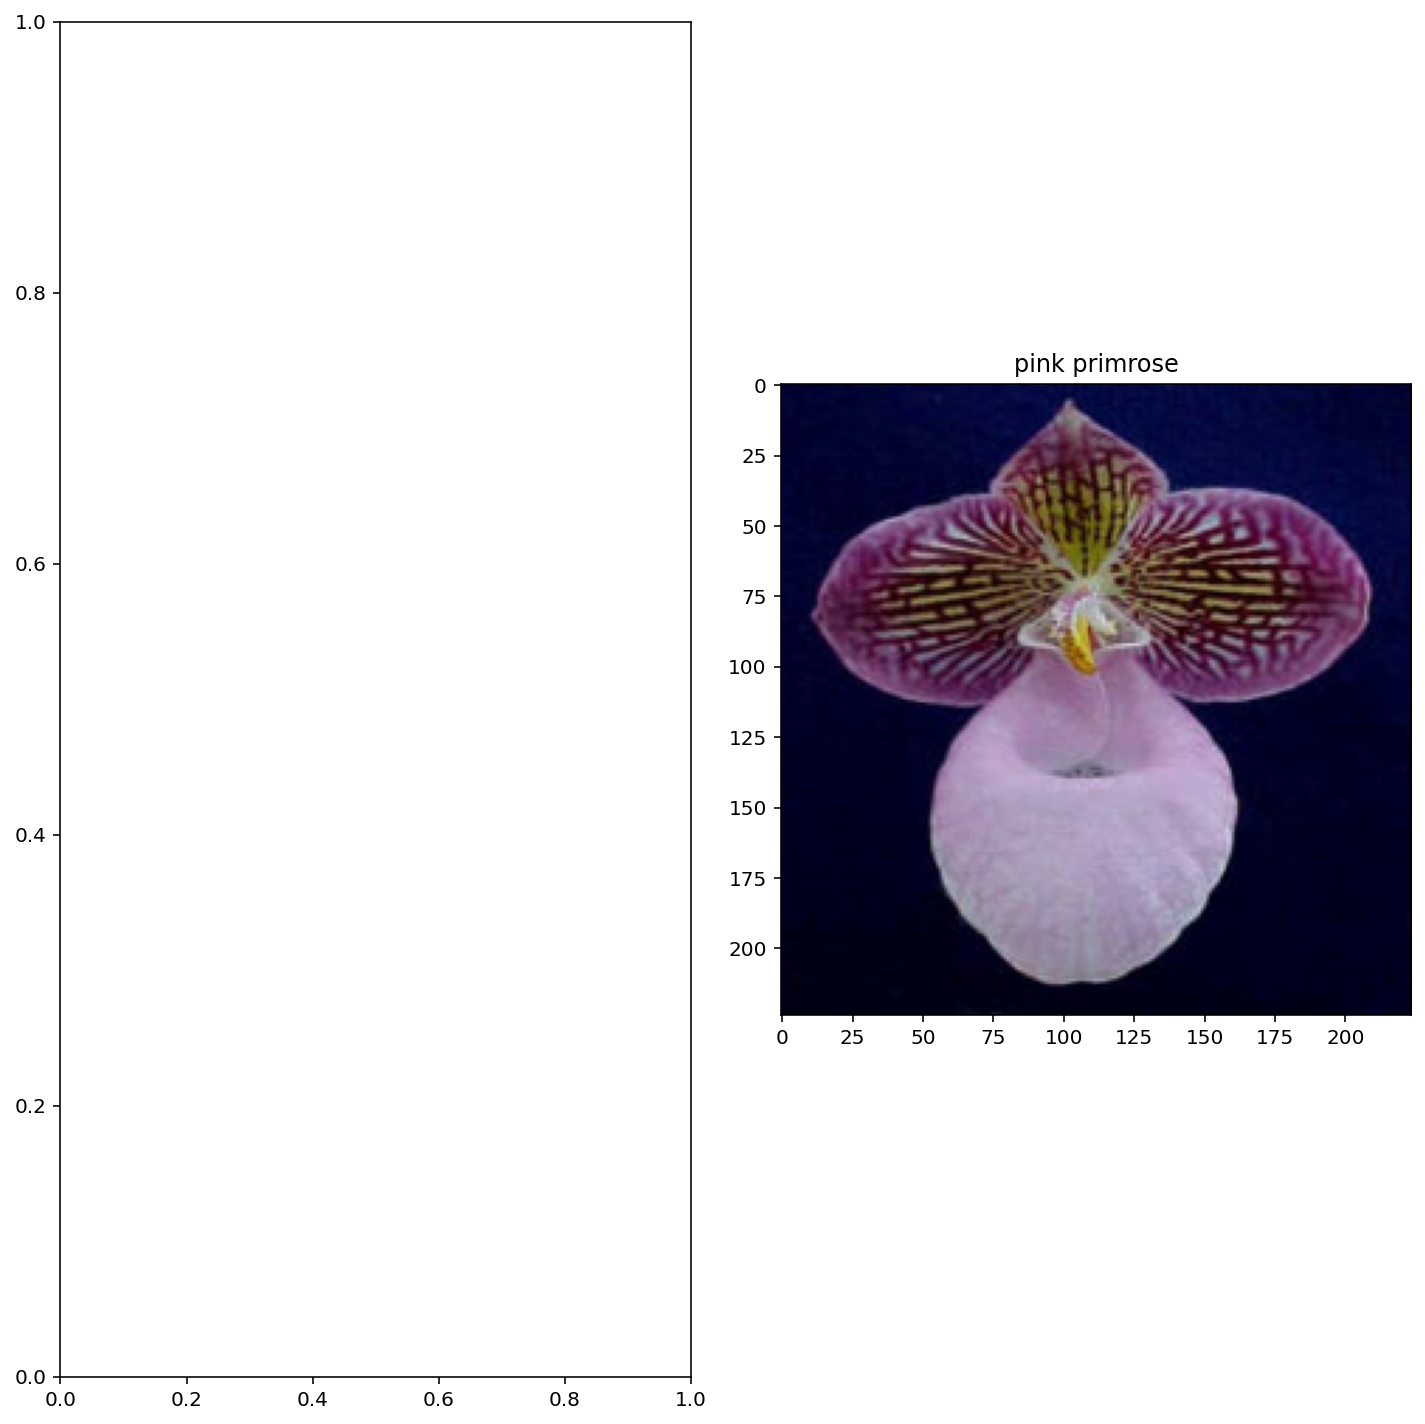

In [57]:
#for the first picture
image_path = './test_images/hard-leaved_pocket_orchid.jpg'
probs, classes = predict(image_path, reloaded_keras_model, 5)
print(probs, classes)
plot_image(image_path,5)

KeyError: 40

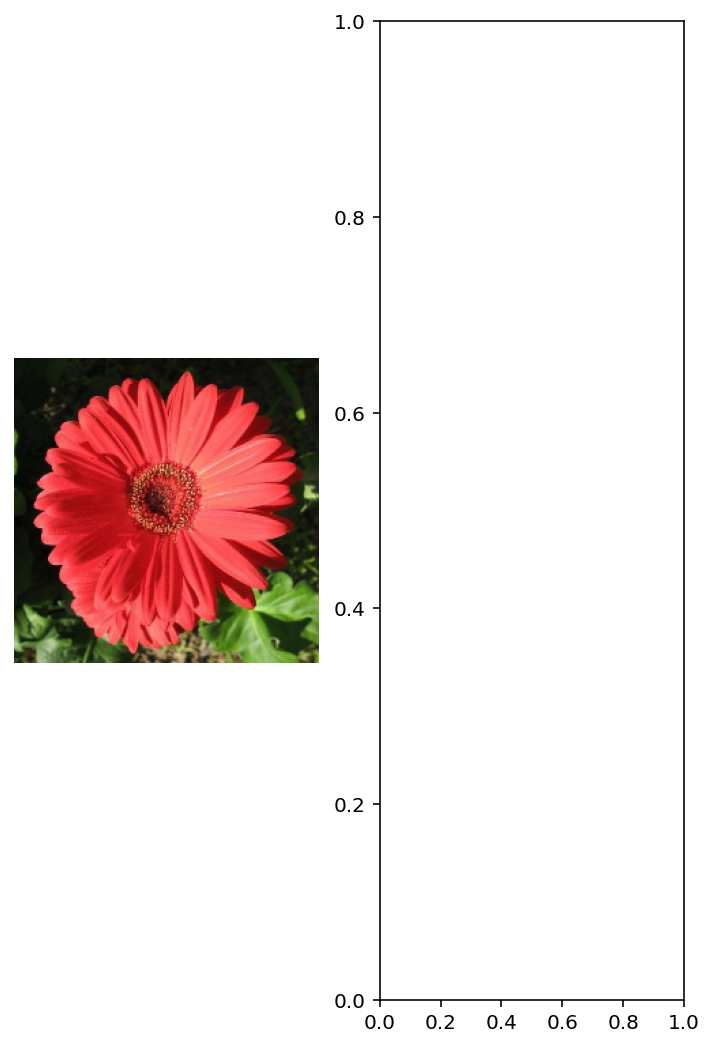

In [65]:
image_path ='./test_images/'

for image_batch, label_batch in image_path.take(1):
    ps = my_model.predict(image_batch)
    first_image = image_batch.numpy().squeeze()[0]
    first_label = label_batch.numpy()[0]

fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(first_image, cmap = plt.cm.binary)
ax1.axis('off')
ax1.set_title(class_names[first_label])
ax2.barh(np.arange(10), ps[0])
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(class_names, size='small');
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)
plt.tight_layout()